In [199]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init

import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('/Users/ponynie/Developer/Python_Code/IntroDMLabChula/Final_Project/children anemia.csv')
data.dropna(inplace=True)

data.drop(['Anemia level.1', 'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)', 'When child put to breast', 'Current marital status'], axis=1, inplace=True)

data = data[data['Had fever in last two weeks'].isin(['Yes', 'No'])]
data = data[data['Taking iron pills, sprinkles or syrup'].isin(['Yes', 'No'])]

data.head(10)

,Age in 5-year groups,Type of place of residence,Highest educational level,Wealth index combined,Births in last five years,Age of respondent at 1st birth,Anemia level,Have mosquito bed net for sleeping (from household questionnaire),Smokes cigarettes,Currently residing with husband/partner,Had fever in last two weeks,Hemoglobin level adjusted for altitude (g/dl - 1 decimal),"Taking iron pills, sprinkles or syrup"
3,25-29,Urban,Secondary,Richest,1,25,Moderate,Yes,No,Living with her,No,114.0,No
6,35-39,Urban,Secondary,Richest,2,32,Not anemic,Yes,No,Living with her,No,102.0,Yes
9,20-24,Urban,Secondary,Richest,1,19,Moderate,Yes,No,Living with her,No,113.0,Yes
12,25-29,Urban,Higher,Richest,1,24,Mild,Yes,No,Living with her,No,109.0,No
13,20-24,Urban,Higher,Richest,2,19,Mild,Yes,No,Living with her,No,96.0,Yes
18,25-29,Urban,Secondary,Richest,2,22,Moderate,Yes,No,Living with her,No,96.0,Yes
21,25-29,Urban,Secondary,Richer,1,23,Mild,Yes,No,Living with her,No,96.0,No
22,25-29,Urban,Secondary,Richer,2,20,Mild,Yes,No,Living with her,No,115.0,Yes
25,25-29,Urban,Secondary,Richer,2,20,Not anemic,Yes,No,Staying elsewhere,No,110.0,No
36,30-34,Urban,No education,Richest,3,25,Not anemic,Yes,No,Living with her,No,138.0,No


In [200]:
categorical_columns = ['Age in 5-year groups', 'Type of place of residence', 'Highest educational level', 'Wealth index combined', 'Have mosquito bed net for sleeping (from household questionnaire)', 'Smokes cigarettes', 'Currently residing with husband/partner', 'Had fever in last two weeks', 'Taking iron pills, sprinkles or syrup']
numerical_columns = ['Births in last five years', 'Age of respondent at 1st birth', 'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)']
label_columns = 'Anemia level'

for category in categorical_columns:
    data[category] = data[category].astype('category')
data['Anemia level'] = data['Anemia level'].astype('category')

for categorical in categorical_columns:
    print(data[categorical].cat.categories, categorical)
print(data['Anemia level'].cat.categories, "Label")

Index(['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49'], dtype='object') Age in 5-year groups
Index(['Rural', 'Urban'], dtype='object') Type of place of residence
Index(['Higher', 'No education', 'Primary', 'Secondary'], dtype='object') Highest educational level
Index(['Middle', 'Poorer', 'Poorest', 'Richer', 'Richest'], dtype='object') Wealth index combined
Index(['No', 'Yes'], dtype='object') Have mosquito bed net for sleeping (from household questionnaire)
Index(['No', 'Yes'], dtype='object') Smokes cigarettes
Index(['Living with her', 'Staying elsewhere'], dtype='object') Currently residing with husband/partner
Index(['No', 'Yes'], dtype='object') Had fever in last two weeks
Index(['No', 'Yes'], dtype='object') Taking iron pills, sprinkles or syrup
Index(['Mild', 'Moderate', 'Not anemic', 'Severe'], dtype='object') Label


In [201]:
categorical_np = [data[i].cat.codes.values for i in categorical_columns]
categorical_data = np.stack(categorical_np, 1)
categorical_data[:10]

array([[2, 1, 3, 4, 1, 0, 0, 0, 0],
       [4, 1, 3, 4, 1, 0, 0, 0, 1],
       [1, 1, 3, 4, 1, 0, 0, 0, 1],
       [2, 1, 0, 4, 1, 0, 0, 0, 0],
       [1, 1, 0, 4, 1, 0, 0, 0, 1],
       [2, 1, 3, 4, 1, 0, 0, 0, 1],
       [2, 1, 3, 3, 1, 0, 0, 0, 0],
       [2, 1, 3, 3, 1, 0, 0, 0, 1],
       [2, 1, 3, 3, 1, 0, 1, 0, 0],
       [3, 1, 1, 4, 1, 0, 0, 0, 0]], dtype=int8)

In [202]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[2, 1, 3, 4, 1, 0, 0, 0, 0],
        [4, 1, 3, 4, 1, 0, 0, 0, 1],
        [1, 1, 3, 4, 1, 0, 0, 0, 1],
        [2, 1, 0, 4, 1, 0, 0, 0, 0],
        [1, 1, 0, 4, 1, 0, 0, 0, 1],
        [2, 1, 3, 4, 1, 0, 0, 0, 1],
        [2, 1, 3, 3, 1, 0, 0, 0, 0],
        [2, 1, 3, 3, 1, 0, 0, 0, 1],
        [2, 1, 3, 3, 1, 0, 1, 0, 0],
        [3, 1, 1, 4, 1, 0, 0, 0, 0]])

In [203]:
numerical_data = np.stack([data[i].values for i in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:10]

tensor([[  1.,  25., 114.],
        [  2.,  32., 102.],
        [  1.,  19., 113.],
        [  1.,  24., 109.],
        [  2.,  19.,  96.],
        [  2.,  22.,  96.],
        [  1.,  23.,  96.],
        [  2.,  20., 115.],
        [  2.,  20., 110.],
        [  3.,  25., 138.]])

In [204]:
outputs = torch.tensor(data['Anemia level'].cat.codes.values).flatten()
outputs[:10]

tensor([1, 2, 1, 0, 0, 1, 0, 0, 2, 2], dtype=torch.int8)

In [205]:
categorical_data.shape, numerical_data.shape, outputs.shape

(torch.Size([5855, 9]), torch.Size([5855, 3]), torch.Size([5855]))

In [206]:
categorical_column_sizes = [len(data[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(7, 4), (2, 1), (4, 2), (5, 3), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1)]


In [207]:
total_records = data.shape[0]
test_records = int(total_records * .2) # 20% of the data for testing
train_records = total_records - test_records # 80% of the data for training

categorical_train_data = categorical_data[:train_records]
categorical_test_data = categorical_data[train_records:]
numerical_train_data = numerical_data[:train_records]
numerical_test_data = numerical_data[train_records:]
train_label = outputs[:train_records]
test_label = outputs[train_records:]

print(categorical_train_data.shape, categorical_test_data.shape)
print(numerical_train_data.shape, numerical_test_data.shape)
print(train_label.shape, test_label.shape)

torch.Size([4684, 9]) torch.Size([1171, 9])
torch.Size([4684, 3]) torch.Size([1171, 3])
torch.Size([4684]) torch.Size([1171])


In [209]:
hidden_layers = [200,100,50]
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 4, hidden_layers, p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(7, 4)
    (1): Embedding(2, 1)
    (2): Embedding(4, 2)
    (3): Embedding(5, 3)
    (4-8): 5 x Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=F

In [210]:
if torch.backends.mps.is_available():
    print ("MPS device found.")
else:
    print("MPS device not found.")

mps_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model.to(mps_device)
categorical_train_data = categorical_train_data.to(mps_device)
numerical_train_data = numerical_train_data.to(mps_device)
categorical_test_data = categorical_test_data.to(mps_device)
numerical_test_data = numerical_test_data.to(mps_device)
train_label = train_label.to(mps_device)
test_label = test_label.to(mps_device)  

MPS device found.


In [211]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 300

epoch:   1 loss: 1.57070923
epoch:  26 loss: 1.38983250
epoch:  51 loss: 1.33824348
epoch:  76 loss: 1.29204154
epoch: 101 loss: 1.26308870
epoch: 126 loss: 1.22606480
epoch: 151 loss: 1.19639969
epoch: 176 loss: 1.17212725
epoch: 201 loss: 1.14855337
epoch: 226 loss: 1.14391756
epoch: 251 loss: 1.13060248
epoch: 276 loss: 1.13973606
epoch: 300 loss: 1.1283679008


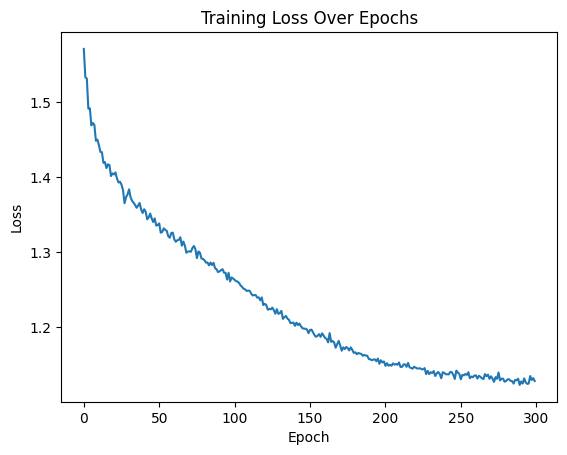

In [212]:
aggregated_losses = []

for i in range(epochs):
    i += 1
    pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(pred, train_label)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

aggregated_losses_on_cpu = [tensor.detach().cpu() for tensor in aggregated_losses]
plt.plot(range(epochs), aggregated_losses_on_cpu)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [213]:
with torch.no_grad():
    eval = model(categorical_test_data, numerical_test_data)
    loss = loss_function(eval, test_label)
print(f'Loss: {loss:.8f}')

Loss: 1.11138439


In [214]:
print(eval[:5])
eval = np.argmax(eval.detach().cpu(), axis=1)
print(eval[:5])

tensor([[ 0.6069,  1.1795,  0.5981, -4.0613],
        [ 0.7118,  0.8387,  1.1211, -3.1973],
        [ 0.6270,  1.1304,  0.8440, -2.4254],
        [ 0.5758,  0.5573,  0.4282,  0.0383],
        [ 0.1543,  0.1995,  0.8045, -2.7376]], device='mps:0')
tensor([1, 2, 1, 0, 2])


In [215]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
test_label = test_label.detach().cpu()
print(confusion_matrix(test_label,eval))
print("--------------------------------------------------------------------------------")
print(classification_report(test_label,eval))
print("--------------------------------------------------------------------------------")
print(f"accuracy: {accuracy_score(test_label, eval)*100} %")

[[  5 109 199   0]
 [  4 111 177   2]
 [  2 142 407   1]
 [  0   3   9   0]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.02      0.03       313
           1       0.30      0.38      0.34       294
           2       0.51      0.74      0.61       552
           3       0.00      0.00      0.00        12

    accuracy                           0.45      1171
   macro avg       0.32      0.28      0.24      1171
weighted avg       0.44      0.45      0.38      1171

--------------------------------------------------------------------------------
accuracy: 44.662681468830066 %
